Loading dataset...
Dataset loaded: 1087 reviews
Applying pseudo-labeling...

Label distribution:
Advertisement: 5 (0.5%)
Irrelevant: 17 (1.6%)
Rant_no_visit: 1 (0.1%)
Trustworthy: 1064 (97.9%)


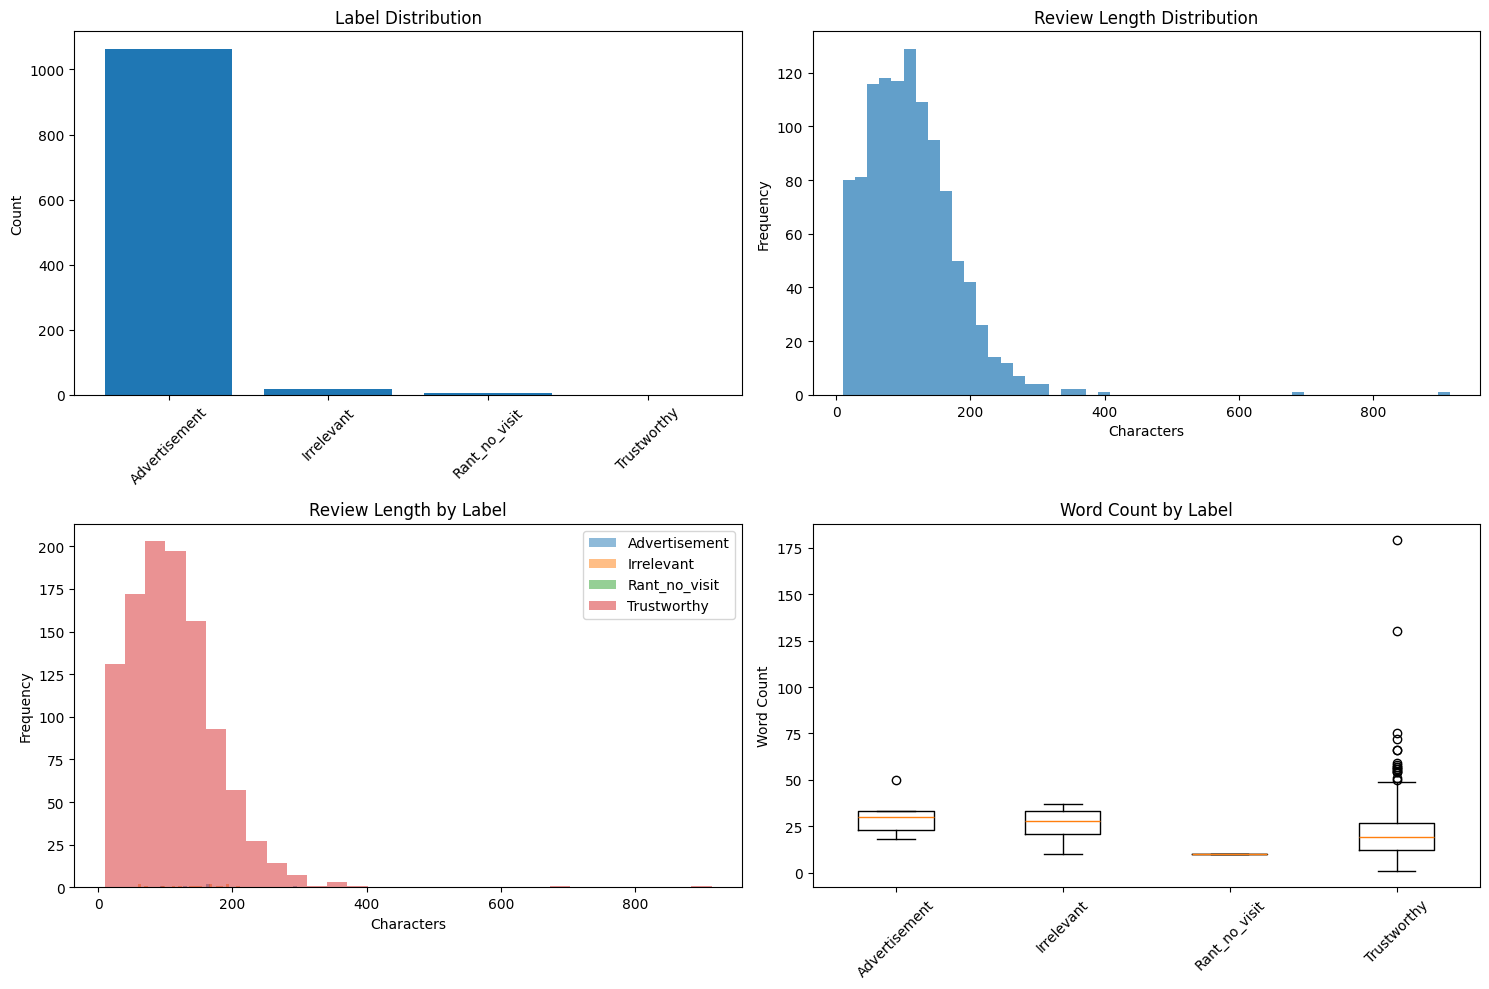

Preparing datasets...


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [2]:
# Enhanced Trustworthiness Classifier for Google Maps Reviews
# ===============================
# Dependencies Installation
# ===============================
# !pip install transformers datasets accelerate evaluate sentencepiece protobuf huggingface_hub
# !pip install scikit-learn pandas numpy matplotlib seaborn torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Transformers and HuggingFace
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    EarlyStoppingCallback
)
import evaluate
import torch

class TrustworthinessClassifier:
    """
    A comprehensive trustworthiness classifier for Google Maps reviews.
    """
    
    def __init__(self, model_name="distilbert-base-uncased"):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.label_names = ["Advertisement", "Irrelevant", "Rant_no_visit", "Trustworthy"]
        self.label2id = {label: i for i, label in enumerate(self.label_names)}
        self.id2label = {i: label for i, label in enumerate(self.label_names)}
        
    def load_and_preprocess_data(self, csv_path):
        """
        Load and preprocess the reviews dataset.
        """
        print("Loading dataset...")
        df = pd.read_csv(csv_path)
        
        # Handle different possible column names
        if 'text' in df.columns:
            df = df.rename(columns={'text': 'review'})
        elif 'review_text' in df.columns:
            df = df.rename(columns={'review_text': 'review'})
        
        # Clean the data
        df = df.dropna(subset=['review'])
        df['review'] = df['review'].astype(str)
        
        # Remove very short reviews (likely noise)
        df = df[df['review'].str.len() >= 10]
        
        print(f"Dataset loaded: {len(df)} reviews")
        return df
    
    def enhanced_pseudo_labeling(self, review):
        """
        Enhanced rule-based pseudo-labeling with more sophisticated patterns.
        """
        text = review.lower().strip()
        
        # Advertisement patterns
        ad_patterns = [
            r'\b(discount|promo|offer|sale|deal|coupon|free|50%|off)\b',
            r'\b(www\.|http|\.com|\.net)\b',
            r'\b(call|phone|contact|visit our)\b.*\b(website|store)\b',
            r'\b(limited time|hurry|act now|order now)\b',
            r'\b(special offer|great deal|amazing price)\b'
        ]
        
        # Irrelevant patterns (not about the restaurant/place)
        irrelevant_patterns = [
            r'\b(car|vehicle|automobile|parking lot|gas station|traffic)\b',
            r'\b(phone|mobile|iphone|android|app crash|technical issue)\b',
            r'\b(delivery|uber|doordash|grubhub|postmates|driver)\b',
            r'\b(weather|rain|snow|politics|news|sports)\b',
            r'\b(home|house|apartment|neighbor|family drama)\b'
        ]
        
        # Rant without visit patterns
        rant_patterns = [
            r'\b(never been|haven\'t visited|heard it\'s|people say|someone told me)\b',
            r'\b(looks dirty|appears|seems like|probably|i bet)\b.*\b(bad|terrible|awful)\b',
            r'\b(drive by|passed by|walked past)\b.*\b(dirty|messy|crowded)\b',
            r'\b(reviews are|ratings are|people complain)\b'
        ]
        
        # Check for advertisement
        if any(re.search(pattern, text) for pattern in ad_patterns):
            return 0  # Advertisement
            
        # Check for irrelevant content
        if any(re.search(pattern, text) for pattern in irrelevant_patterns):
            return 1  # Irrelevant
            
        # Check for rant without visit
        if any(re.search(pattern, text) for pattern in rant_patterns):
            return 2  # Rant_no_visit
            
        # Additional heuristics for trustworthy reviews
        trustworthy_indicators = [
            r'\b(ate|ordered|tried|tasted|visited|went to)\b',
            r'\b(server|waiter|waitress|staff|service)\b',
            r'\b(food was|meal was|experience was|atmosphere was)\b',
            r'\b(recommend|worth|will return|come back)\b'
        ]
        
        # If contains trustworthy indicators, likely trustworthy
        if any(re.search(pattern, text) for pattern in trustworthy_indicators):
            return 3  # Trustworthy
            
        # Default to trustworthy if no negative patterns found
        return 3  # Trustworthy
    
    def apply_pseudo_labels(self, df):
        """
        Apply pseudo-labeling to the dataset.
        """
        print("Applying pseudo-labeling...")
        df['label'] = df['review'].apply(self.enhanced_pseudo_labeling)
        
        # Display label distribution
        label_counts = df['label'].value_counts().sort_index()
        print("\nLabel distribution:")
        for idx, count in label_counts.items():
            print(f"{self.label_names[idx]}: {count} ({count/len(df)*100:.1f}%)")
        
        return df
    
    def visualize_data(self, df):
        """
        Visualize the dataset characteristics.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Label distribution
        label_counts = df['label'].value_counts()
        axes[0, 0].bar(range(len(label_counts)), label_counts.values)
        axes[0, 0].set_xticks(range(len(self.label_names)))
        axes[0, 0].set_xticklabels(self.label_names, rotation=45)
        axes[0, 0].set_title('Label Distribution')
        axes[0, 0].set_ylabel('Count')
        
        # Review length distribution
        df['review_length'] = df['review'].str.len()
        axes[0, 1].hist(df['review_length'], bins=50, alpha=0.7)
        axes[0, 1].set_title('Review Length Distribution')
        axes[0, 1].set_xlabel('Characters')
        axes[0, 1].set_ylabel('Frequency')
        
        # Review length by label
        for i, label in enumerate(self.label_names):
            subset = df[df['label'] == i]['review_length']
            axes[1, 0].hist(subset, alpha=0.5, label=label, bins=30)
        axes[1, 0].set_title('Review Length by Label')
        axes[1, 0].set_xlabel('Characters')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        
        # Word count distribution
        df['word_count'] = df['review'].str.split().str.len()
        axes[1, 1].boxplot([df[df['label'] == i]['word_count'].values for i in range(len(self.label_names))],
                          labels=self.label_names)
        axes[1, 1].set_title('Word Count by Label')
        axes[1, 1].set_ylabel('Word Count')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def prepare_datasets(self, df, test_size=0.2, val_size=0.1):
        """
        Prepare train/validation/test datasets.
        """
        print("Preparing datasets...")
        
        # First split: train + val vs test
        train_val_df, test_df = train_test_split(
            df, test_size=test_size, random_state=42, stratify=df['label']
        )
        
        # Second split: train vs val
        train_df, val_df = train_test_split(
            train_val_df, test_size=val_size/(1-test_size), random_state=42, stratify=train_val_df['label']
        )
        
        # Convert to HuggingFace datasets
        train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
        val_dataset = Dataset.from_pandas(val_df[['review', 'label']])
        test_dataset = Dataset.from_pandas(test_df[['review', 'label']])
        
        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': val_dataset,
            'test': test_dataset
        })
        
        print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")
        return dataset_dict
    
    def tokenize_datasets(self, datasets):
        """
        Tokenize the datasets.
        """
        print("Tokenizing datasets...")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        def tokenize_function(examples):
            return self.tokenizer(
                examples['review'],
                padding='max_length',
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
        
        tokenized_datasets = datasets.map(tokenize_function, batched=True)
        return tokenized_datasets
    
    def setup_model_and_training(self):
        """
        Setup the model and training arguments.
        """
        print("Setting up model...")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=len(self.label_names),
            id2label=self.id2label,
            label2id=self.label2id
        )
        
        # Setup metrics
        self.accuracy_metric = evaluate.load("accuracy")
        self.precision_metric = evaluate.load("precision")
        self.recall_metric = evaluate.load("recall")
        self.f1_metric = evaluate.load("f1")
    
    def compute_metrics(self, eval_pred):
        """
        Compute evaluation metrics.
        """
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        
        accuracy = self.accuracy_metric.compute(predictions=predictions, references=labels)
        precision = self.precision_metric.compute(predictions=predictions, references=labels, average='macro')
        recall = self.recall_metric.compute(predictions=predictions, references=labels, average='macro')
        f1 = self.f1_metric.compute(predictions=predictions, references=labels, average='macro')
        
        return {
            'accuracy': accuracy['accuracy'],
            'precision': precision['precision'],
            'recall': recall['recall'],
            'f1': f1['f1']
        }
    
    def train(self, tokenized_datasets, output_dir="./trustworthiness_model"):
        """
        Train the model.
        """
        print("Starting training...")
        
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f'{output_dir}/logs',
            logging_steps=100,
            evaluation_strategy="steps",
            eval_steps=500,
            save_strategy="steps",
            save_steps=500,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            report_to=None,  # Disable wandb/tensorboard
            seed=42,
            fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
        )
        
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation'],
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        
        # Train the model
        self.trainer.train()
        
        # Save the final model
        self.trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Model saved to {output_dir}")
    
    def evaluate_model(self, tokenized_datasets):
        """
        Evaluate the model on test set.
        """
        print("Evaluating model...")
        
        # Evaluate on test set
        test_results = self.trainer.evaluate(tokenized_datasets['test'])
        print("Test Results:")
        for key, value in test_results.items():
            if key.startswith('eval_'):
                print(f"{key[5:]}: {value:.4f}")
        
        # Get predictions for detailed analysis
        predictions = self.trainer.predict(tokenized_datasets['test'])
        y_pred = np.argmax(predictions.predictions, axis=-1)
        y_true = predictions.label_ids
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.label_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_names,
                   yticklabels=self.label_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return test_results
    
    def create_inference_pipeline(self, model_path="./trustworthiness_model"):
        """
        Create an inference pipeline for predictions.
        """
        self.inference_pipeline = pipeline(
            "text-classification",
            model=model_path,
            tokenizer=model_path,
            return_all_scores=False
        )
        return self.inference_pipeline
    
    def predict(self, texts, model_path="./trustworthiness_model"):
        """
        Predict trustworthiness for new texts.
        """
        if not hasattr(self, 'inference_pipeline'):
            self.create_inference_pipeline(model_path)
        
        if isinstance(texts, str):
            texts = [texts]
        
        results = []
        for text in texts:
            pred = self.inference_pipeline(text)[0]
            label_id = int(pred['label'].split('_')[-1])
            results.append({
                'text': text,
                'prediction': self.label_names[label_id],
                'confidence': pred['score']
            })
        
        return results

# ===============================
# Main execution function
# ===============================
def main():
    """
    Main function to run the complete pipeline.
    """
    # Initialize classifier
    classifier = TrustworthinessClassifier()
    
    # Load and preprocess data
    csv_path = "dataset/reviews.csv"
    df = classifier.load_and_preprocess_data(csv_path)
    
    # Apply pseudo-labeling
    df = classifier.apply_pseudo_labels(df)
    
    # Visualize data
    classifier.visualize_data(df)
    
    # Prepare datasets
    datasets = classifier.prepare_datasets(df)
    
    # Tokenize datasets
    tokenized_datasets = classifier.tokenize_datasets(datasets)
    
    # Setup model
    classifier.setup_model_and_training()
    
    # Train model
    classifier.train(tokenized_datasets)
    
    # Evaluate model
    test_results = classifier.evaluate_model(tokenized_datasets)
    
    # Test inference
    test_texts = [
        "The food was amazing and the service was excellent. I'll definitely come back!",
        "Never been here but I heard from my friends that it's terrible.",
        "Visit our website for 50% discount on all meals! Limited time offer!",
        "The delivery driver was rude and my phone battery died during the trip.",
        "Great atmosphere, friendly staff, and delicious pasta. Highly recommended!"
    ]
    
    print("\n" + "="*50)
    print("INFERENCE EXAMPLES")
    print("="*50)
    
    predictions = classifier.predict(test_texts)
    for result in predictions:
        print(f"\nReview: {result['text']}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.3f}")
        print("-" * 50)

# ===============================
# Run the pipeline
# ===============================
if __name__ == "__main__":
    main()